# Building Nonlinear Core Correction from PStudio AE Data

Changing the hight of the NLCC from AE core density

In [1]:
import sys, os
sys.path.append(os.path.abspath('/projectsn/mp1009_1/Valeria/NLPP_high_temperature/PStudio/'))
import numpy as np
import matplotlib.pyplot as plt
from dftpy.field import DirectField
from dftpy.formats import io
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from pstudio.oncvpsp_routines.oncvpsp import hartree
from dftpy.optimization import Optimization
from dftpy.ions import Ions
from dftpy.grid import DirectGrid
from dftpy.math_utils import ecut2nr
from ase import Atoms
from dftpy.math_utils import ecut2nr
from dftpy.constants import Units

## PStudio

In [2]:
from math import pi
from pstudio import AE, set_output
set_output('-')
ae = AE('Ag', config='[Kr] 4d10 5s1', xcname='LDA-py')
ae.run()
r = ae.rgd.r
rho = ae.rho
rc = 1.7 #/ Units.Bohr  # core matching radius (can be tuned)

def split_function(r, rc):
    fg = 0.5 * (1 + np.cos(-(r - rc) / rc * np.pi))
    fl = 0.5 * (1 - np.cos(-(r - rc) / rc * np.pi))
    f_g = np.ones_like(r)
    f_g[r < rc] = fg[r < rc]
    f_l = np.ones_like(r)
    f_l[r > 0] = fl[r > 0]
    f_l[r > rc] = 0.0
    return f_l, f_g

l, g = split_function(r, rc)
rho_core_array = (rho * l) * 4 * pi * r**2



scalar relativistic atomic calculation for Ag (Silver, Z=47)
configuration: 1s2 2s2 2p6 3s2 3p6 3d10 4s2 4p6 4d10 5s1, 47 electrons
exchange-correlation: LDA-python
2001 radial gridpoints in [1e-05,100]

Converged in 52 iterations

Energy contributions:
------------------------------------------------------------------------
Kinetic:    +5516.245782 Ha    +150104.693253 eV 
Ionic:     -12842.849803 Ha    -349471.743327 eV 
Hartree:    +2159.595659 Ha    +58765.591076 eV 
XC:          -144.124492 Ha     -3921.827175 eV 
------------------------------------------------------------------------
Total:      -5311.132659 Ha    -144523.280888 eV 

state      eigenvalue      eigenvalue        rmax
------------------------------------------------------------------------
1s2       -929.721610 Ha -25299.013595 eV    0.020 
2s2       -136.922654 Ha -3725.855195 eV    0.114 
2p6       -122.897115 Ha -3344.200832 eV    0.091 
3s2        -25.084394 Ha  -682.581132 eV    0.333 
3p6        -20.477576 

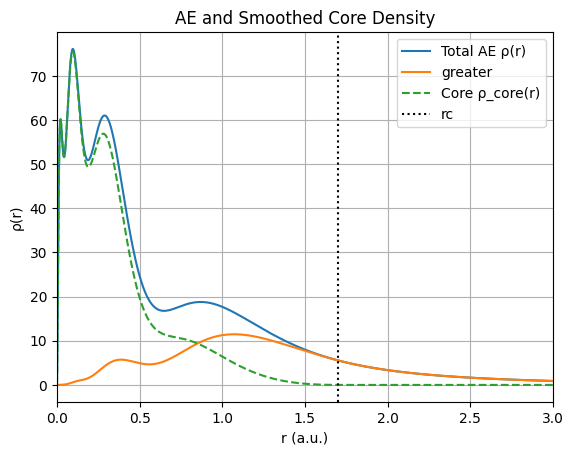

In [3]:
plt.plot(r, rho * 4 * pi * r**2, label='Total AE ρ(r)')
plt.plot(r,rho*g*4*pi*r**2,label="greater")

plt.plot(r, rho_core_array, label='Core ρ_core(r)', linestyle='--')
plt.axvline(rc, color='k', linestyle=':', label='rc')
plt.xlabel("r (a.u.)")
plt.ylabel("ρ(r)")
plt.legend()
plt.grid(True)
plt.title("AE and Smoothed Core Density")
plt.xlim(0,3)
plt.show()


##  Build Nonlinear Core Correction (NLCC) Field

In [4]:
import numpy as np
from scipy.optimize import root
from scipy.interpolate import interp1d
from scipy.misc import derivative

def construct_core_density_smooth(r, r_core, rho_core_array, r_pc):
    rho_interp = interp1d(r, rho_core_array, kind='cubic', bounds_error=False, fill_value=0.0)
    f0 = rho_interp(r_pc)
    f0_prime = derivative(rho_interp, r_pc, dx=1e-4)

    def equations(params):
        b, c = params
        a = np.log(f0 / r_pc**2) - b * r_pc**2 - c * r_pc**4
        term1 = 2 * r_pc * np.exp(a + b * r_pc**2 + c * r_pc**4)
        term2 = r_pc**2 * np.exp(a + b * r_pc**2 + c * r_pc**4) * (2 * b * r_pc + 4 * c * r_pc**3)
        dcore = term1 + term2
        return [dcore - f0_prime, ] 
        
    def solve_with_c(c_fixed):
        def single_eq(b):
            return equations([b, c_fixed])[0]
        b_sol = root(single_eq, 0.1).x[0]
        return b_sol, c_fixed

    c_try = 0.0
    b_fit, c_fit = solve_with_c(c_try)
    a_fit = np.log(f0 / r_pc**2) - b_fit * r_pc**2 - c_fit * r_pc**4

    rhoc = np.zeros_like(r_core)
    inner_mask = r_core < r_pc
    outer_mask = ~inner_mask
    rhoc[inner_mask] = r_core[inner_mask]**2 * np.exp(a_fit + b_fit * r_core[inner_mask]**2 + c_fit * r_core[inner_mask]**4)
    rhoc[outer_mask] = rho_interp(r_core[outer_mask])
    return rhoc


In [5]:
from dftpy.functional import LocalPseudo, Functional, TotalFunctional

In [6]:
ions_ag, rho_target_ag, _ = io.read_all('/projectsn/mp1009_1/Valeria/NLPP/All_elements/rho_ref/rho_Ag_gbrv.xsf')
grid = rho_target_ag.grid

path_ngbrv = '/projectsn/mp1009_1/Valeria/NLPP/NPP_0.2/'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_gbrv_new.psp8'}

path_gbrv = '/projectsn/mp1009_1/Valeria/NLPP/PP/'
PP_list_gbrv_ag = {'Ag': path_gbrv+'ag_lda_v1.4.uspp.F.UPF'}

nr = ecut2nr(ecut=600, lattice=ions_ag.cell)
grid = DirectGrid(lattice=ions_ag.cell, nr=nr)

pseudo_gbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_gbrv_ag)
pseudo_gbrv_ag.local_PP()
v_gbrv_ag = pseudo_gbrv_ag.readpp.pp['Ag'].v

pseudo_ngbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_ag)
pseudo_ngbrv_ag.local_PP()
v_ngbrv_ag = pseudo_ngbrv_ag.readpp.pp['Ag'].v

setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/PP/ag_lda_v1.4.uspp.F.UPF
setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/NPP_0.2//Ag_gbrv_new.psp8


In [7]:
core_density_gbrv = pseudo_gbrv_ag.readpp.pp['Ag'].core_density
v_gbrv = pseudo_gbrv_ag.readpp.pp['Ag'].v
r_gbrv = pseudo_gbrv_ag.readpp.pp['Ag'].r
r_core = pseudo_gbrv_ag.readpp.pp['Ag'].core_density_grid

In [8]:
r0 = 0.7
core_density = construct_core_density_smooth(r=r, r_pc=r0, r_core=r_gbrv, rho_core_array=rho_core_array)

(0.0, 4.0)

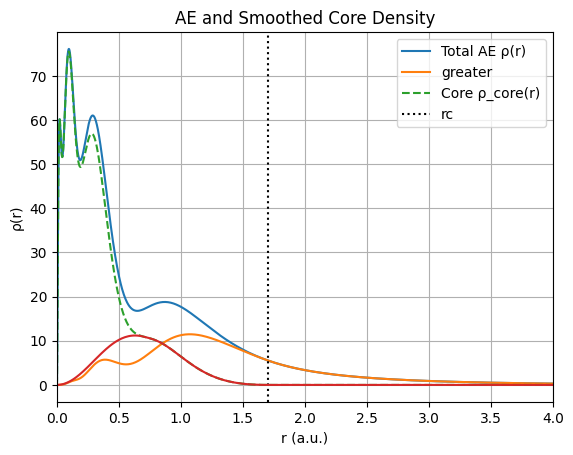

In [9]:
plt.plot(r, rho * 4 * pi * r**2, label='Total AE ρ(r)')
plt.plot(r,rho*g*4*pi*r**2,label="greater")

plt.plot(r, rho_core_array, label='Core ρ_core(r)', linestyle='--')
plt.axvline(rc, color='k', linestyle=':', label='rc')
plt.xlabel("r (a.u.)")
plt.ylabel("ρ(r)")
plt.legend()
plt.grid(True)
plt.title("AE and Smoothed Core Density")
plt.xlim(-0.010,3)
# # plt.show()

plt.plot(r_core, core_density)
plt.xlim(0,4)

In [10]:
r_safe = r_gbrv.copy()
r_safe[r_safe == 0] = 1e-8


### Build gaussians with different strenght (hight)

In [11]:
core_1 = core_density/4/np.pi/r_safe**2
core_2 = core_density/4/np.pi/r_safe**2 /2
core_4 = core_density/4/np.pi/r_safe**2 /4
core_8 = core_density/4/np.pi/r_safe**2 /8


(-0.01, 3.0)

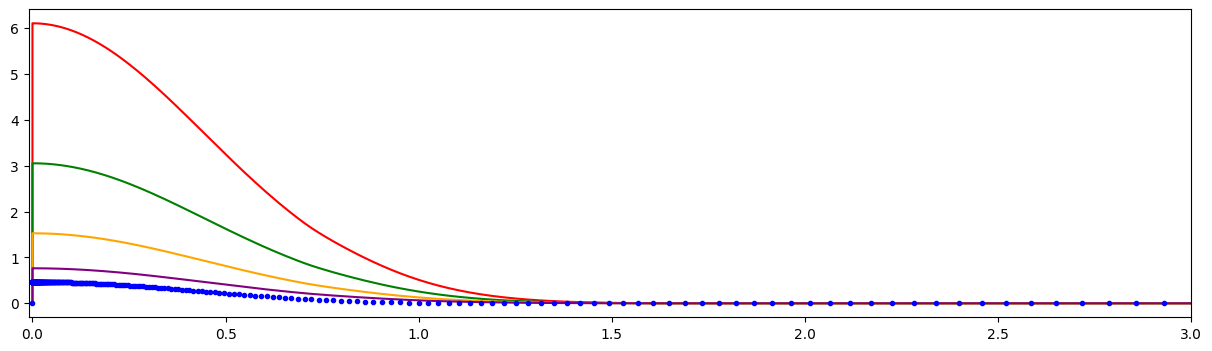

In [12]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,4))
axs.plot(r_gbrv, core_1.ravel(), 'r')
axs.plot(r_gbrv, core_2.ravel(), 'g')
axs.plot(r_gbrv, core_4.ravel(), color='orange')
axs.plot(r_gbrv, core_8.ravel(), color='purple')

axs.plot(r_gbrv, core_density_gbrv.ravel(), 'b.')

# axs[1].plot(r_ngbrv, (v_ngbrv_ag).ravel(), 'r')
# axs[1].plot(r_gbrv, v_gbrv_ag.ravel(), 'b.')
axs.set_xlim(-0.01,3)
# axs[1].set_xlim(0.0,4)

In [13]:
path_ngbrv = '/projectsn/mp1009_1/Valeria/NLPP/NPP_0.2/'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_gbrv_new.psp8'}

key = 'Ag'
r = pseudo_ngbrv_ag.readpp.pp[key].r
vl = pseudo_ngbrv_ag.readpp.pp[key].v
zval = pseudo_ngbrv_ag.zval[key]

from dftpy.functional.pseudo.psp import PSP
engine = PSP(None)
engine.r = r
engine.v = vl
engine.info['atomicnum'] = 27
engine.info['fchrg'] = 1.0
engine.info['mmax'] = len(r)
engine._zval = zval
engine._core_density_grid = r


In [14]:
engine._core_density = core_1 *4*np.pi#* 4* np.pi
engine.write('Ag_AE_1_gbrv.psp8')

In [15]:
engine._core_density = core_2 *4*np.pi#* 4* np.pi
engine.write('Ag_AE_2_gbrv.psp8')

In [16]:
engine._core_density = core_4 *4*np.pi#* 4* np.pi
engine.write('Ag_AE_4_gbrv.psp8')

In [17]:
engine._core_density = core_8 *4*np.pi#* 4* np.pi
engine.write('Ag_AE_8_gbrv.psp8')

In [18]:
path_ngbrv = './'
PP_list_ngbrv_1 = {'Ag': path_ngbrv + '/Ag_AE_1_gbrv.psp8'}
PP_list_ngbrv_2 = {'Ag': path_ngbrv + '/Ag_AE_2_gbrv.psp8'}
PP_list_ngbrv_4 = {'Ag': path_ngbrv + '/Ag_AE_4_gbrv.psp8'}
PP_list_ngbrv_8 = {'Ag': path_ngbrv + '/Ag_AE_8_gbrv.psp8'}

In [19]:
pseudo_ngbrv_1 = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_1)
pseudo_ngbrv_2 = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_2)
pseudo_ngbrv_4 = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_4)
pseudo_ngbrv_8 = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_8)

pseudo_ngbrv_1.local_PP()
pseudo_ngbrv_2.local_PP()
pseudo_ngbrv_4.local_PP()
pseudo_ngbrv_8.local_PP()

core_density_1 = pseudo_ngbrv_1.core_density
core_density_2 = pseudo_ngbrv_2.core_density
core_density_4 = pseudo_ngbrv_4.core_density
core_density_8 = pseudo_ngbrv_8.core_density

v_ngbrv_1 = pseudo_ngbrv_1.readpp.pp['Ag'].v
v_ngbrv_2 = pseudo_ngbrv_2.readpp.pp['Ag'].v
v_ngbrv_4 = pseudo_ngbrv_4.readpp.pp['Ag'].v
v_ngbrv_8 = pseudo_ngbrv_8.readpp.pp['Ag'].v

core_density_ngbrv_1 = pseudo_ngbrv_1.readpp.pp['Ag'].core_density
core_density_ngbrv_2 = pseudo_ngbrv_2.readpp.pp['Ag'].core_density
core_density_ngbrv_4 = pseudo_ngbrv_4.readpp.pp['Ag'].core_density
core_density_ngbrv_8 = pseudo_ngbrv_8.readpp.pp['Ag'].core_density

r_ngbrv = pseudo_ngbrv_ag.readpp.pp['Ag'].r
# r_core = pseudo_ngbrv_ag.readpp.pp['Ag'].core_density_grid

setting key: Ag -> .//Ag_AE_1_gbrv.psp8
setting key: Ag -> .//Ag_AE_2_gbrv.psp8
setting key: Ag -> .//Ag_AE_4_gbrv.psp8
setting key: Ag -> .//Ag_AE_8_gbrv.psp8
Warning 0.0019244498071592695
Warning 0.0009622249036919051
Warning 0.00048111245183313065
Warning 0.00024055622590732752


(0.0, 4.0)

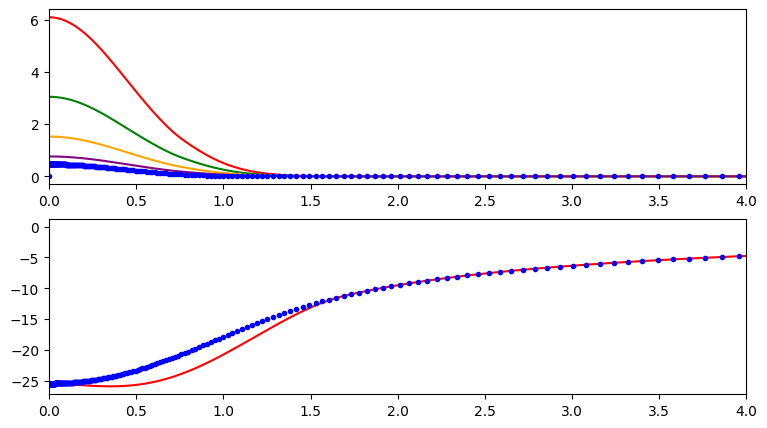

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9,5))
axs[0].plot(r, (core_density_ngbrv_1).ravel(), 'r')
axs[0].plot(r, (core_density_ngbrv_2).ravel(), 'g')
axs[0].plot(r, (core_density_ngbrv_4).ravel(), color='orange')
axs[0].plot(r, (core_density_ngbrv_8).ravel(), color='purple')

axs[0].plot(r_gbrv, core_density_gbrv.ravel(), 'b.')

axs[1].plot(r_ngbrv, (v_ngbrv_ag).ravel(), 'r')
axs[1].plot(r_gbrv, v_gbrv_ag.ravel(), 'b.')
axs[0].set_xlim(0.0,4)
axs[1].set_xlim(0.0,4)

In [21]:
core_density_gbrv = pseudo_gbrv_ag.core_density

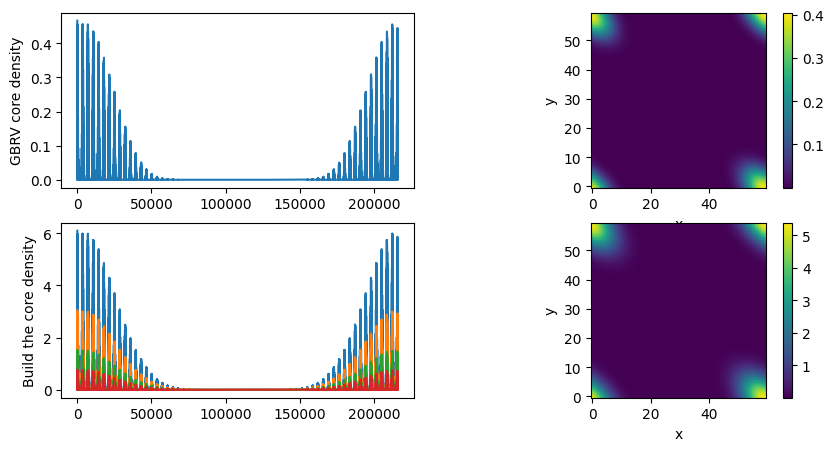

In [22]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
axs[0,0].plot(core_density_gbrv.ravel())

z_slice = 3
im1 = axs[0,1].imshow(core_density_gbrv[:, :, z_slice], origin='lower', cmap='viridis')
fig.colorbar(im1, ax=axs[0,1], orientation='vertical')

axs[0,1].set_xlabel("x")
axs[0,1].set_ylabel("y")

axs[0,0].set_ylabel("GBRV core density")

axs[1,0].set_ylabel("Build the core density")

axs[1,0].plot(core_density_1.ravel())
axs[1,0].plot(core_density_2.ravel())
axs[1,0].plot(core_density_4.ravel())
axs[1,0].plot(core_density_8.ravel())

im2=axs[1,1].imshow(core_density_1[:, :, z_slice], origin='lower', cmap='viridis')
fig.colorbar(im2, ax=axs[1,1], orientation='vertical')

axs[1,1].set_xlabel("x")
axs[1,1].set_ylabel("y")

plt.show()

### Analisys of vlines_core

In [23]:
from scipy.interpolate import splrep, splev
from dftpy.math_utils import quartic_interpolation
def calc_vlines(pseudo, gps, vps, interps):
    vlines = {}
    reciprocal_grid = pseudo.grid.get_reciprocal()
    q = reciprocal_grid.q
    vloc = np.empty_like(q)
    for key in sorted(interps):
        interp = interps[key]
        if interp is None :
            vlines[key] = None
            continue
        vloc[:] = 0.0
        mask = q < gps[key][-1]
        qmask = q[mask]
        if len(qmask)>0 :
            vloc[mask] = splev(qmask, interp, der=0)
        # quartic interpolation for small q
        # -----------------------------------------------------------------------
        mask = q < gps[key][1]
        vp = vps[key]
        dp = gps[key][1] - gps[key][0]
        f = [vp[2], vp[1], vp[0], vp[1], vp[2]]
        dx = q[mask] / dp
        vloc[mask] = quartic_interpolation(f, dx)
        # -----------------------------------------------------------------------
        vlines[key] = vloc.copy()
    return vlines


In [24]:
vlines = calc_vlines(pseudo_ngbrv_ag, pseudo_ngbrv_ag.readpp._core_density_grid, pseudo_ngbrv_ag.readpp._core_density, pseudo_ngbrv_ag.vloc_interp_core)

## Analysis in reciprocal space 

In [25]:
import numpy as np
from dftpy.functional import TotalFunctional
from dftpy.optimization import Optimization
from copy import deepcopy

def compute_numerical_forces(ions, energy_evaluator, dr=1e-4):
    n_atoms = ions.nat
    forces = np.zeros((n_atoms, 3))
    positions0 = ions.positions.copy()

    for i in range(n_atoms):
        for j in range(3):
            ions_plus = deepcopy(ions)
            ions_plus.positions[i, j] += dr
            PSEUDO = LocalPseudo(grid = grid, ions=ions_plus, PP_list=PP_list_ngbrv_ag)
            eval_plus = TotalFunctional(KE=energy_evaluator.KE,
                                         XC=energy_evaluator.XC,
                                         HARTREE=energy_evaluator.HARTREE,
                                         PSEUDO=PSEUDO)
            eval_plus.ions = ions_plus
            rho_ini = DirectField(grid=grid)
            rho_ini[:] = ions_plus.get_ncharges()/ions_plus.cell.volume
            opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                   optimization_method = 'CG')
            rho_plus = opt.optimize_rho(guess_rho=rho_ini)
            E_plus = eval_plus.Energy(rho_plus)
            
            ions_minus = deepcopy(ions)
            ions_minus.positions[i, j] -= dr
            PSEUDO = LocalPseudo(grid = grid, ions=ions_minus, PP_list=PP_list_ngbrv_ag)
            eval_minus = TotalFunctional(KE=energy_evaluator.KE,
                                          XC=energy_evaluator.XC,
                                          HARTREE=energy_evaluator.HARTREE,
                                          PSEUDO=PSEUDO)
            eval_minus.ions = ions_minus
            rho_ini = DirectField(grid=grid)
            rho_ini[:] = ions_minus.get_ncharges()/ions_minus.cell.volume
            opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                   optimization_method = 'CG')
            rho_minus = opt.optimize_rho(guess_rho=rho_ini)
            E_minus = eval_minus.Energy(rho_minus)
            E_minus = eval_minus.Energy(rho_minus)

            forces[i, j] = -(E_plus - E_minus) / (2 * dr)

    ions.positions[:] = positions0
    return forces

def calc_force_cc(potential = None, rhod = None, rhov=None, ions = None):
    """Calculate the correction forces

    Parameters
    ----------
    potential : field
        Potential in real space.
    rhod :
        density of each element in reciprocal space
    """
    #
    # if rhod is None : rhod = self.vlines_core
    if ions is None : ions = ions
    grid = potential.grid
    #
    reciprocal_grid = grid.get_reciprocal()
    forces = np.zeros((ions.nat, 3))
    mask = reciprocal_grid.mask
    g = reciprocal_grid.g
    rhovg = rhov.fft()
    if potential.rank == 2 : potential = 0.5*(potential[0]+potential[1])
    potg = potential.fft()

    for key in sorted(ions.zval):
            rhocg = rhod
            if rhocg is None : continue
            for i in range(ions.nat):
                if ions.symbols[i] == key:
                    strf = ions.istrf(reciprocal_grid, i)
                    den = (potg[mask] * rhocg[mask] * strf[mask]).imag
                    for j in range(3):
                        forces[i, j] = np.einsum("i, i->", g[j][mask], den)
    forces *= - 2.0 / grid.volume ## Should be negative
    return forces


In [26]:
def get_energy(KE, XC, ions, PSEUDO):
    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
    evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                       optimization_method = 'CG')
    rho = opt.optimize_rho(guess_rho=rho_ini)
    forces = evaluator.get_forces(rho=rho)
    forces_ewald = evaluator.ewald.forces
    v = KE(rho).potential
    return evaluator.Energy(rho=rho, ions=ions), rho, forces, evaluator, forces_ewald

In [27]:
HARTREE = Functional(type='HARTREE')

In [28]:
from ase import Atoms
F_ngbrv_1 = []
F_ngbrv_2 = []
F_ngbrv_4 = []
F_ngbrv_8 = []
E_ngbrv_1 = []
E_ngbrv_2 = []
E_ngbrv_4 = []
E_ngbrv_8 = []

V = []

opt_options = {'econv' : 1e-10}
alats = [1.15, 1.2, 1.4, 1.6]#, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]#, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]
L = 10
for alat in alats:
    atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
    atoms.set_cell([L, L, L])
    ions = Ions.from_ase(atoms)
    grid = DirectGrid(lattice=ions.cell, ecut=40)
    print(grid.spacings[0], grid.nr)
    PSEUDO_1 = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_ngbrv_1)
    PSEUDO_2 = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_ngbrv_2)
    PSEUDO_4 = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_ngbrv_4)
    PSEUDO_8 = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_ngbrv_8)
    
    core_1 = PSEUDO_1.core_density
    core_2 = PSEUDO_2.core_density
    core_4 = PSEUDO_4.core_density
    core_8 = PSEUDO_8.core_density
        
    XC_1 = Functional(type='XC',name='LDA', core_density=core_1, pseudo=PSEUDO_1, libxc=False)
    KE_1 = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core_1, pseudo=PSEUDO_1)
    
    XC_2 = Functional(type='XC',name='LDA', core_density=core_2, pseudo=PSEUDO_2, libxc=False)
    KE_2 = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core_2, pseudo=PSEUDO_2)

    XC_4 = Functional(type='XC',name='LDA', core_density=core_4, pseudo=PSEUDO_4, libxc=False)
    KE_4 = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core_4, pseudo=PSEUDO_4)  
    
    XC_8 = Functional(type='XC',name='LDA', core_density=core_8, pseudo=PSEUDO_8, libxc=False)
    KE_8 = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core_8, pseudo=PSEUDO_8)

    
    ene_ngbrv_1, rho_1, forces_1, evaluator_1 , forces_ewald_1= get_energy(KE_1, XC_1, ions, PSEUDO_1)
    ene_ngbrv_2, rho_2, forces_2, evaluator_2 , forces_ewald_2= get_energy(KE_2, XC_2, ions, PSEUDO_2)
    ene_ngbrv_4, rho_4, forces_4, evaluator_4 , forces_ewald_4= get_energy(KE_4, XC_4, ions, PSEUDO_4)
    ene_ngbrv_8, rho_8, forces_8, evaluator_8 , forces_ewald_8= get_energy(KE_8, XC_8, ions, PSEUDO_8)

    
    # F_num.append(forces_num)
    F_ngbrv_1.append(forces_1)
    F_ngbrv_2.append(forces_2)
    F_ngbrv_4.append(forces_4)
    F_ngbrv_8.append(forces_8)
    
    E_ngbrv_1.append(ene_ngbrv_1)
    E_ngbrv_2.append(ene_ngbrv_2)
    E_ngbrv_4.append(ene_ngbrv_4)
    E_ngbrv_8.append(ene_ngbrv_8)



0.34994928256239416 [54 54 54]
setting key: Ag -> .//Ag_AE_1_gbrv.psp8
setting key: Ag -> .//Ag_AE_2_gbrv.psp8
setting key: Ag -> .//Ag_AE_4_gbrv.psp8
setting key: Ag -> .//Ag_AE_8_gbrv.psp8
Warning 0.04209845515380311
Warning 0.0210492275768488
Warning 0.010524613788441104
Warning 0.005262306894224366
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.223234532187E+02      1.223235E+02    1.780333E+02    1       1       8.311272E-02    
1       -1.530172672612E+02     -2.753407E+02   4.158124E+02    1       4       2.206032E-01    
2       -2.004484432772E+02     -4.743118E+01   6.188919E+01    1       2       2.929840E-01    
3       -2.057921625077E+02     -5.343719E+00   1.377064E+01    1       2       3.587615E-01    
4       -2.068873995875E+02     -1.095237E+00   5.376425E+00    1       2       4.253581E-01    
5       -2.073188708913E+02     -4.314713E-01   1.133627E+00    1       2       4.913981E-01    
6       -2.074615

In [29]:
atom1_x_anl_1 = [F_ngbrv_1[0][0][0], F_ngbrv_1[1][0][0], F_ngbrv_1[2][0][0], F_ngbrv_1[3][0][0]]
atom1_x_anl_2 = [F_ngbrv_2[0][0][0], F_ngbrv_2[1][0][0], F_ngbrv_2[2][0][0], F_ngbrv_2[3][0][0]]
atom1_x_anl_4 = [F_ngbrv_4[0][0][0], F_ngbrv_4[1][0][0], F_ngbrv_4[2][0][0], F_ngbrv_4[3][0][0]]
atom1_x_anl_8 = [F_ngbrv_8[0][0][0], F_ngbrv_8[1][0][0], F_ngbrv_8[2][0][0], F_ngbrv_8[3][0][0]]

atom2_x_anl_1 = [F_ngbrv_1[0][1][0], F_ngbrv_1[1][1][0], F_ngbrv_1[2][1][0], F_ngbrv_1[3][1][0]]
atom2_x_anl_2 = [F_ngbrv_2[0][1][0], F_ngbrv_2[1][1][0], F_ngbrv_2[2][1][0], F_ngbrv_2[3][1][0]]
atom2_x_anl_4 = [F_ngbrv_4[0][1][0], F_ngbrv_4[1][1][0], F_ngbrv_4[2][1][0], F_ngbrv_4[3][1][0]]
atom2_x_anl_8 = [F_ngbrv_8[0][1][0], F_ngbrv_8[1][1][0], F_ngbrv_8[2][1][0], F_ngbrv_8[3][1][0]]

atom1_y_anl_1 = [F_ngbrv_1[0][0][1], F_ngbrv_1[1][0][1], F_ngbrv_1[2][0][1], F_ngbrv_1[3][0][1]]
atom1_y_anl_2 = [F_ngbrv_2[0][0][1], F_ngbrv_2[1][0][1], F_ngbrv_2[2][0][1], F_ngbrv_2[3][0][1]]
atom1_y_anl_4 = [F_ngbrv_4[0][0][1], F_ngbrv_4[1][0][1], F_ngbrv_4[2][0][1], F_ngbrv_4[3][0][1]]
atom1_y_anl_8 = [F_ngbrv_8[0][0][1], F_ngbrv_8[1][0][1], F_ngbrv_8[2][0][1], F_ngbrv_8[3][0][1]]

atom2_y_anl_1 = [F_ngbrv_1[0][1][1], F_ngbrv_1[1][1][1], F_ngbrv_1[2][1][1], F_ngbrv_1[3][1][1]]
atom2_y_anl_2 = [F_ngbrv_2[0][1][1], F_ngbrv_2[1][1][1], F_ngbrv_2[2][1][1], F_ngbrv_2[3][1][1]]
atom2_y_anl_4 = [F_ngbrv_4[0][1][1], F_ngbrv_4[1][1][1], F_ngbrv_4[2][1][1], F_ngbrv_4[3][1][1]]
atom2_y_anl_8 = [F_ngbrv_8[0][1][1], F_ngbrv_8[1][1][1], F_ngbrv_8[2][1][1], F_ngbrv_8[3][1][1]]

atom1_z_anl_1 = [F_ngbrv_1[0][0][2], F_ngbrv_1[1][0][2], F_ngbrv_1[2][0][2], F_ngbrv_1[3][0][2]]
atom1_z_anl_2 = [F_ngbrv_2[0][0][2], F_ngbrv_2[1][0][2], F_ngbrv_2[2][0][2], F_ngbrv_2[3][0][2]]
atom1_z_anl_4 = [F_ngbrv_4[0][0][2], F_ngbrv_4[1][0][2], F_ngbrv_4[2][0][2], F_ngbrv_4[3][0][2]]
atom1_z_anl_8 = [F_ngbrv_8[0][0][2], F_ngbrv_8[1][0][2], F_ngbrv_8[2][0][2], F_ngbrv_8[3][0][2]]

atom2_z_anl_1 = [F_ngbrv_1[0][1][2], F_ngbrv_1[1][1][2], F_ngbrv_1[2][1][2], F_ngbrv_1[3][1][2]]
atom2_z_anl_2 = [F_ngbrv_2[0][1][2], F_ngbrv_2[1][1][2], F_ngbrv_2[2][1][2], F_ngbrv_2[3][1][2]]
atom2_z_anl_4 = [F_ngbrv_4[0][1][2], F_ngbrv_4[1][1][2], F_ngbrv_4[2][1][2], F_ngbrv_4[3][1][2]]
atom2_z_anl_8 = [F_ngbrv_8[0][1][2], F_ngbrv_8[1][1][2], F_ngbrv_8[2][1][2], F_ngbrv_8[3][1][2]]

Text(0.5, 0, 'r($\\AA$)')

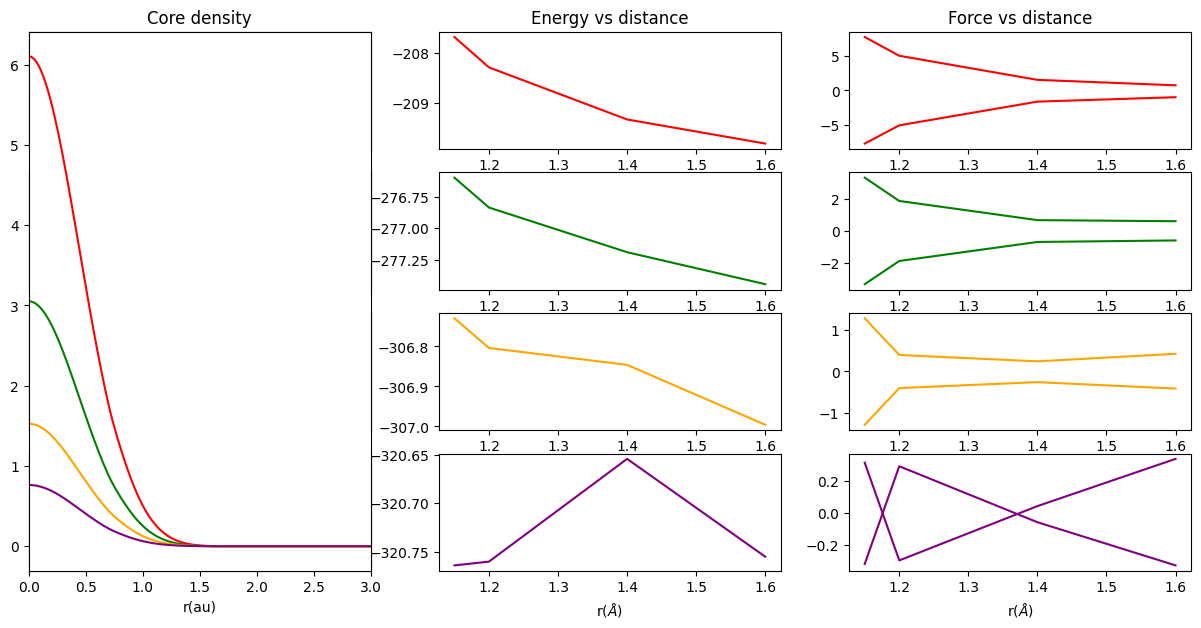

In [31]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15,7))

ax1 = plt.subplot(131) 
ax1.plot(r, (core_density_ngbrv_1).ravel(), 'r')
ax1.plot(r, (core_density_ngbrv_2).ravel(), 'g')
ax1.plot(r, (core_density_ngbrv_4).ravel(), color='orange')
ax1.plot(r, (core_density_ngbrv_8).ravel(), color='purple')
ax1.set_xlim(0,3)
ax1.set_xlabel('r(au)')
ax1.set_title('Core density')

# ax.set_xticks([])
axs[0,0].set_yticks([])
axs[1,0].set_yticks([])
axs[2,0].set_yticks([])
axs[3,0].set_yticks([])

axs[0,0].set_xticks([])
axs[1,0].set_xticks([])
axs[2,0].set_xticks([])
axs[3,0].set_xticks([])

axs[0,1].set_title('Energy vs distance')
axs[0,1].plot(alats, np.asarray(E_ngbrv_1).ravel(), 'r')
axs[1,1].plot(alats, np.asarray(E_ngbrv_2).ravel(), 'g')
axs[2,1].plot(alats, np.asarray(E_ngbrv_4).ravel(), color='orange')
axs[3,1].plot(alats, np.asarray(E_ngbrv_8).ravel(), color='purple')
axs[3,1].set_xlabel(r'r($\AA$)')

axs[0,2].set_title('Force vs distance')
axs[0,2].plot(alats, np.asarray(atom1_x_anl_1 ).ravel(), 'r')
axs[1,2].plot(alats, np.asarray(atom1_x_anl_2 ).ravel(), 'g')
axs[2,2].plot(alats, np.asarray(atom1_x_anl_4 ).ravel(), color='orange')
axs[3,2].plot(alats, np.asarray(atom1_x_anl_8 ).ravel(), color='purple')

axs[0,2].plot(alats, np.asarray(atom2_x_anl_1 ).ravel(), 'r')
axs[1,2].plot(alats, np.asarray(atom2_x_anl_2 ).ravel(), 'g')
axs[2,2].plot(alats, np.asarray(atom2_x_anl_4 ).ravel(), color='orange')
axs[3,2].plot(alats, np.asarray(atom2_x_anl_8 ).ravel(), color='purple')
axs[3,2].set_xlabel(r'r($\AA$)')
